In [2]:
import numpy as np
import xarray as xr
import stmat
import geopandas as gpd
import shapely as sp

Initialize raster coordinate information:

In [3]:
minx = 5 
maxx = 10
miny = 50
maxy = 55
dx = 0.5 #Resolution in x
dy = 0.5 #Resolution in y

nx = (maxx - minx)/dx
ny = (maxy - miny)/dy

xras = np.arange(minx, maxx, dx)
yras = np.arange(miny, maxy, dy)

xxras, yyras =np.meshgrid(xras,yras) #Raster meshgrid
print (xxras.shape)

(10, 10)


Create synthetic data 

In [4]:
n_points = 10000
n_time = 1

synthetic h2ph data

In [5]:
stack = np.empty((n_points,0))

for i in range(1):
    slc= np.random.random((100,100))
    stack = np.append(stack, slc[0:100,0:100].reshape(n_points,1), axis=1)

stack = np.array(stack*10, dtype='int')
print(stack.shape)


(10000, 1)


Case 1: synthetic coords (sorted in x and y)

In [6]:
x = np.sort(np.random.random(100)*(maxx - minx) + minx)
y = np.sort(np.random.random(100)*(maxy - miny) + miny)

In [7]:
xx, yy = np.meshgrid(x,y)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)

In [9]:
stack_xx = np.empty((n_points,0))
stack_yy = np.empty((n_points,0))

for i in range(1):
    stack_xx = np.append(stack_xx, xxreshape, axis=1)
    stack_yy = np.append(stack_yy, yyreshape, axis=1)


Create Xarray object with coordinates as variables

In [10]:
data_xr = xr.Dataset(data_vars=dict(h2ph=(["points", "time"], stack), xv=(["points","time"],stack_xx),yv=(["points","time"],stack_yy),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr

<xarray.Dataset>
Dimensions:  (points: 10000, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * time     (time) int64 0
Data variables:
    h2ph     (points, time) int64 4 4 8 7 4 9 2 3 3 3 4 ... 8 6 9 2 2 6 8 1 3 7
    xv       (points, time) float64 5.059 5.092 5.139 ... 9.501 9.764 9.915
    yv       (points, time) float64 50.09 50.09 50.09 ... 54.99 54.99 54.99

Import rasterio and related module for rasterize

In [11]:
import rasterio
from rasterio import features
from rasterio import enums
import affine
import matplotlib.pyplot as plt

Convert xarray to geopandas data-frame for use in rasterize

In [10]:
df = data_xr.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.h2ph, geometry=gpd.points_from_xy(df.xv,df.yv))

gdf.sort_values('h2ph')

,h2ph,geometry
3195,0,POINT (9.85427 51.82315)
3636,0,POINT (6.65147 52.09543)
3647,0,POINT (7.24889 52.09543)
991,0,POINT (9.63646 50.30864)
3655,0,POINT (7.65289 52.09543)
...,...,...
2316,9,POINT (5.62947 51.28787)
4616,9,POINT (5.62947 52.60672)
1298,9,POINT (9.90247 50.47575)
4591,9,POINT (9.63646 52.49332)


Convert point-set to raster using rasterize with point index as value

In [27]:
grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[9614. 9621. 9632. 9642. 9651. 9663. 9668. 9679. 9686. 9699.]
 [8414. 8421. 8432. 8442. 8451. 8463. 8468. 8479. 8486. 8499.]
 [7114. 7121. 7132. 7142. 7151. 7163. 7168. 7179. 7186. 7199.]
 [6314. 6321. 6332. 6342. 6351. 6363. 6368. 6379. 6386. 6399.]
 [5314. 5321. 5332. 5342. 5351. 5363. 5368. 5379. 5386. 5399.]
 [4214. 4221. 4232. 4242. 4251. 4263. 4268. 4279. 4286. 4299.]
 [3314. 3321. 3332. 3342. 3351. 3363. 3368. 3379. 3386. 3399.]
 [2314. 2321. 2332. 2342. 2351. 2363. 2368. 2379. 2386. 2399.]
 [1714. 1721. 1732. 1742. 1751. 1763. 1768. 1779. 1786. 1799.]
 [1014. 1021. 1032. 1042. 1051. 1063. 1068. 1079. 1086. 1099.]]


Visualize results

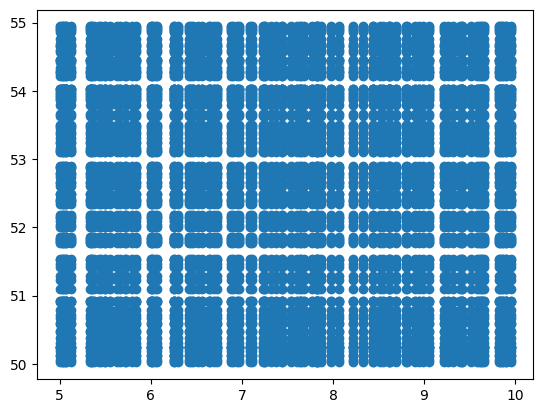

In [31]:
plt.scatter(data_xr.xv, data_xr.yv) #Original complete data-set

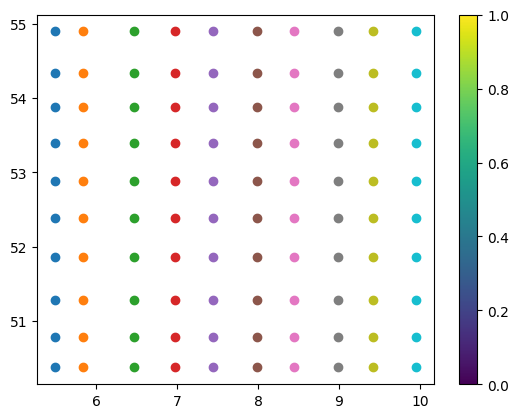

In [35]:
#Plotting subset after densification
for i in np.unique(raster):
    if i is not np.nan:
        plt.scatter(data_xr.xv[np.int64(i)], data_xr.yv[np.int64(i)])
        

Case 2: Clusters of points

In [19]:
n_points = 400
n_time = 1

In [20]:
xx = (np.random.random(400)*(maxx - minx) + minx)
yy = (np.random.random(400)*(maxy - miny) + miny)
xxreshape = xx.reshape(n_points,1)
yyreshape = yy.reshape(n_points,1)

In [48]:
stack_xx_c2 = np.empty((n_points,0))
stack_yy_c2 = np.empty((n_points,0))

for i in range(1):
    stack_xx_c2 = np.append(stack_xx_c2, xxreshape, axis=1)
    stack_yy_c2 = np.append(stack_yy_c2, yyreshape, axis=1)

data_xr_c2 = xr.Dataset(data_vars=dict(xv=(["points","time"],stack_xx_c2),yv=(["points","time"],stack_yy_c2),),
                     coords=dict(
                        points=np.arange(n_points),
                        time=np.arange(n_time),
                        ))

data_xr_c2

<xarray.Dataset>
Dimensions:  (points: 400, time: 1)
Coordinates:
  * points   (points) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * time     (time) int64 0
Data variables:
    xv       (points, time) float64 6.177 5.9 6.737 5.063 ... 5.678 6.962 9.734
    yv       (points, time) float64 50.84 52.9 51.81 52.43 ... 51.04 53.02 50.09

In [29]:
df = data_xr_c2.to_dataframe().reset_index()

gdf = gpd.GeoDataFrame(
    df.index, geometry=gpd.points_from_xy(df.xv,df.yv))

grid_cell  = ((shapes) for shapes in zip(gdf.geometry, gdf.index))
raster = rasterio.features.rasterize(shapes=grid_cell, out_shape =[10,10], fill=np.NAN, all_touched= True, default_value=1, transform=affine.Affine.from_gdal(5.0, 0.5, 0.0, 54.9, 0.0, -0.5)) #, merge_alg= MergeAlg.replace
print (raster)

[[371. 381. 193. 241. 250. 359. 380. 164. 376. 319.]
 [130. 228. 328. 392. 394. 214. 357. 176. 341. 323.]
 [285. 382. 135. 311. 326. 320. 350. 304. 387. 296.]
 [317. 353. 271. 398. 369. 318. 355.  nan 374. 393.]
 [240. 315. 222. 194. 149. 277. 327.  nan 306. 158.]
 [384. 344. 372.  80. 209. 303. 385. 378. 358. 373.]
 [375. 352. 325. 379. 386. 336.  81. 300. 331. 377.]
 [ 31. 397. 330. 370.  25. 312. 348. 390. 293. 284.]
 [151. 329. 364. 368. 333. 396. 360. 177. 295. 363.]
 [262. 309. 140. 389. 391. 252. 395. 128. 132. 399.]]


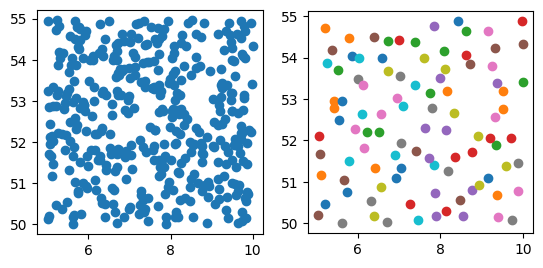

In [70]:
plt.subplot(1, 2, 1, aspect = 'equal')
plt.scatter(data_xr_c2.xv, data_xr_c2.yv) #Original complete data-set

plt.subplot(1, 2, 2, aspect = 'equal')
#Plotting subset after densification
for i in np.unique(raster):
    if not np.isnan(i):
        plt.scatter(data_xr_c2.xv[np.int64(i)], data_xr_c2.yv[np.int64(i)])